# Proyek akhir ML Terapan: Rekomendasi makanan

# Nama: Novianto

Proyek ini akan membuat sistem rekomendasi untuk makanan.

**Business Understanding**

Dalam konteks makanan, banyak pengguna sering merasa kewalahan dengan banyaknya pilihan yang tersedia. Mereka kesulitan menemukan makanan yang sesuai dengan preferensi mereka, baik karena keterbatasan informasi, waktu, maupun pengalaman. Hal ini menyebabkan pengalaman pengguna yang kurang optimal, penurunan loyalitas, dan potensi kehilangan pendapatan bagi platform makanan atau restoran.

**Problem Statements**
1. Makanan apa yang  sesuai dengan preferensi mereka di antara banyaknya pilihan?
2. Makanan apa yang direkomendasikan berdasarkan rating pengguna?

**Goals**

Pengguna mendapatkan rekomendasi makanan yang relevan dan dipersonalisasi oleh pengguna.
Pengguna mendapatkan rekomendasi data seperti nama makanan, jenis makanan, deskripsi, dan rating untuk memahami preferensi pengguna.


Berikut ini adalah langkah yang diperlukan untuk membuat sistem rekomendasi.

# 1. Pemahaman data

Berikut adalah import  library yang diperlukan dalam pembuatan rekomendasi sistem.

In [1]:

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import re
import string

Sistem rekomendasi yang akan dibuat adalah sistem yang akan memberikan rekomendasi makanan berdasarkan rating makanan dalam dataset. Berikut adalah data makanan yang digunakan.

Datase pada proyek ini diambil dari Kaggle
https://www.kaggle.com/datasets/schemersays/food-recommendation-system

In [2]:
food = pd.read_csv('https://raw.githubusercontent.com/novianto13/Proyek-akhir-ML-Terapan/main/Food.csv')
food.head()

,Food_ID,Name,C_Type,Veg_Non,Describe
0,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,3,sweet chilli almonds,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."
3,4,tricolour salad,Healthy Food,veg,"vinegar, honey/sugar, soy sauce, salt, garlic ..."
4,5,christmas cake,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."


In [3]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


Data makanan terdiri dari 5 kolom. yaitu:
1. food_ID yang merupakan ID makanan
2. Nama makanan
3. C_Type yang menunjukkan jenis makanan
4. Veg_Non yang menunjukkan kategori makanan
5. Deskrisi makanan.

Dari info data menunjukkan bahwa terdapat 400 data dengan satu baris data yang nol atau kosong

Berikutnya adalah data rating yang menunjukkan peringkat makanan.

In [4]:
rating = pd.read_csv('https://raw.githubusercontent.com/novianto13/Proyek-akhir-ML-Terapan/main/ratings.csv')
rating.head()

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0


Data rating terdiri dari tiga kolom yaitu:
1. user ID yang menunjukkan ID konsumen
2. Food ID atau kode/ID makanan yang di review
3. Rating yang meunjukkan peringkat makanan

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB


Info  data menunjukkan bahsa ada 512 data dengan satu data nol.

## 1.1 Pemahaman Data food

Setelah load data, maka tahap ini kita akan memahami data lebih lanjut dengan visualisasi dan analisa data awal.

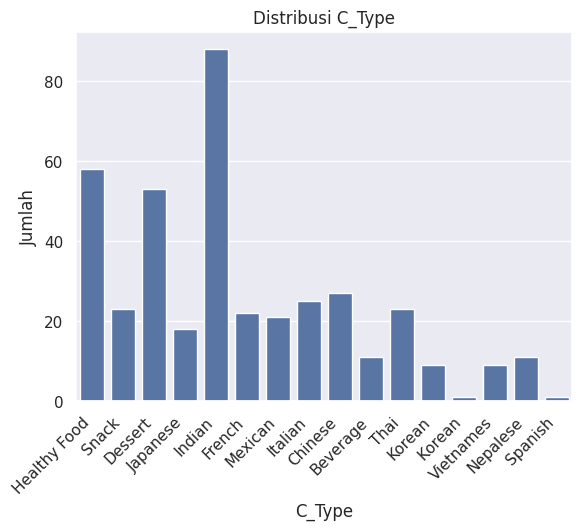

In [6]:
sns.countplot(x='C_Type', data=food)
plt.title('Distribusi C_Type')
plt.xlabel('C_Type')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right') # Rotasi label sumbu x jika diperlukan
plt.show()

Grafik di atas menunjukkan jumlah makanan dalam dataset berdasarkan jenis makanan.  Dari grafik tersebut maka dapat dipahami bahwa jenis makanan indian/india merupakan makanan yang paling banyak dalam menu.

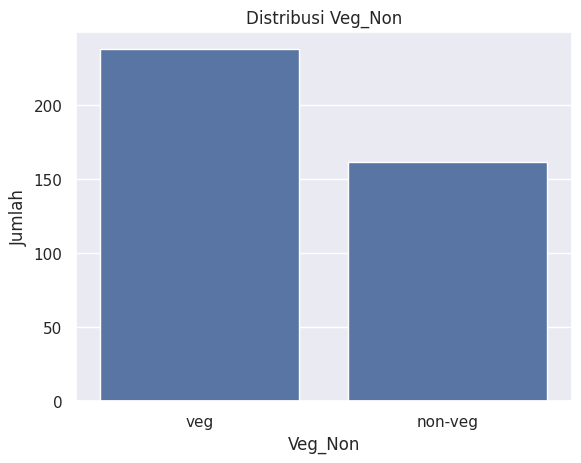

In [7]:
sns.countplot(x='Veg_Non', data=food)
plt.title('Distribusi Veg_Non')
plt.xlabel('Veg_Non')
plt.ylabel('Jumlah')
plt.show()

Grafik di atas adalah perbandingan jumlah kategori makanan vegan dan non vegan. grafik menunjukkan bahwa makanan yang masuk dalam kategori vegan lebih banyak dari pada non vegan.

In [8]:
c_type_counts = food['C_Type'].value_counts()
veg_non_counts = food['Veg_Non'].value_counts()

print("Jumlah data pada C_Type:\n", c_type_counts)
print("\nJumlah data pada Veg_Non:\n", veg_non_counts)

Jumlah data pada C_Type:
 C_Type
Indian          88
Healthy Food    58
Dessert         53
Chinese         27
Italian         25
Snack           23
Thai            23
French          22
Mexican         21
Japanese        18
Beverage        11
Nepalese        11
Korean           9
Vietnames        9
 Korean          1
Spanish          1
Name: count, dtype: int64

Jumlah data pada Veg_Non:
 Veg_Non
veg        238
non-veg    162
Name: count, dtype: int64


Secara jelas, data di atas menunjukkan bahwa terdapat 88 jenis makanan India yang paling banyak dari pada jenis makanan yang lain.

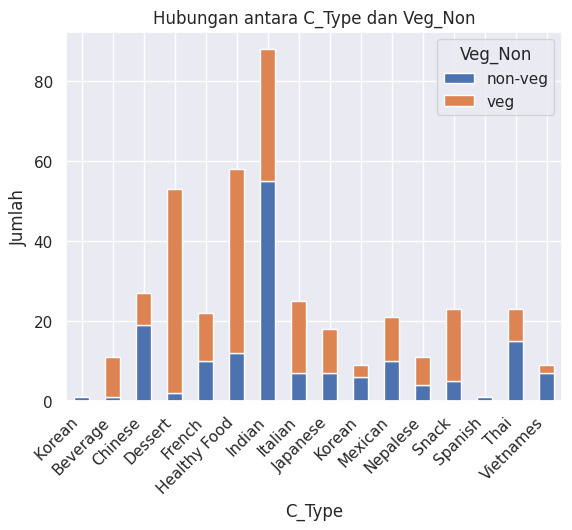

In [9]:
pd.crosstab(food['C_Type'], food['Veg_Non']).plot(kind='bar', stacked=True)
plt.title('Hubungan antara C_Type dan Veg_Non')
plt.xlabel('C_Type')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right') # Rotasi label sumbu x jika diperlukan
plt.legend(title='Veg_Non')
plt.show()

Grafik di atas menunjukkan perbandingan kategori makanan pada setiap jenis makanan. Rincian data dapat dilihat pada keterangan berikut ini

In [10]:
cross_tab = pd.crosstab(food['C_Type'], food['Veg_Non'])
print(cross_tab)

Veg_Non       non-veg  veg
C_Type                    
 Korean             1    0
Beverage            1   10
Chinese            19    8
Dessert             2   51
French             10   12
Healthy Food       12   46
Indian             55   33
Italian             7   18
Japanese            7   11
Korean              6    3
Mexican            10   11
Nepalese            4    7
Snack               5   18
Spanish             1    0
Thai               15    8
Vietnames           7    2


Dari informasi di atas, dapat dipahami bahwa makanan india yang paling banyak adalah masuk kategori Non vegan, sedangkan makanan yang masuk kategori vegan yang paling banyak adalah masuk dalam jenis healty food.

## 1.2. Pemahaman data rating

Berikutnya adalah memahami data rating.

In [11]:
rating.describe()

,User_ID,Food_ID,Rating
count,511.000000,511.000000,511.000000
mean,49.068493,125.311155,5.438356
std,28.739213,91.292629,2.866236
min,1.000000,1.000000,1.000000
25%,25.000000,45.500000,3.000000
50%,49.000000,111.000000,5.000000
75%,72.000000,204.000000,8.000000
max,100.000000,309.000000,10.000000


Data rating meruapakn data yang bersifat angka sehingga bisa dilihat statistik deskriptif. Statistik deskriptif menunjukkan bahwa rata-rata rating yang diberikan olejh pangguna adalah 5.4, sedangkan rating tertinggi adalah 10 dan terendah adalah 1.

In [12]:
print('Jumlah user ID: ', len(rating.User_ID.unique()))
print('Jumlah food ID: ', len(rating.Food_ID.unique()))
print('Jumlah data rating: ', len(rating))

Jumlah user ID:  101
Jumlah food ID:  310
Jumlah data rating:  512


Informasi di atas menunjukkan bahwa  terdapat 512 data, namun ada 1 data yang memiliki nilai 0.

## 1.3. Penggabungan data

tahap ini dilakukan untuk mempersiapkan data yang akan digunakan dalam sistem rekomendasi.

In [13]:
# Menggabungkan dataset food dan rating berdasarkan Food_ID
food_rating = pd.merge(food, rating, on='Food_ID', how='left')

# Menampilkan 5 baris pertama dari dataset yang sudah digabungkan
print(food_rating.head())

   Food_ID                  Name        C_Type  Veg_Non  \
0        1   summer squash salad  Healthy Food      veg   
1        1   summer squash salad  Healthy Food      veg   
2        2  chicken minced salad  Healthy Food  non-veg   
3        2  chicken minced salad  Healthy Food  non-veg   
4        2  chicken minced salad  Healthy Food  non-veg   

                                            Describe  User_ID  Rating  
0  white balsamic vinegar, lemon juice, lemon rin...     49.0     5.0  
1  white balsamic vinegar, lemon juice, lemon rin...     71.0    10.0  
2  olive oil, chicken mince, garlic (minced), oni...      9.0     3.0  
3  olive oil, chicken mince, garlic (minced), oni...     22.0     5.0  
4  olive oil, chicken mince, garlic (minced), oni...     39.0    10.0  


Kode di atas ditujukan untuk dapat menggabungkan data rating dan data food sehinga informasi yang diperoleh lebih lengkap.

In [14]:
# Mengelompokkan data berdasarkan 'Food_Name' dan menghitung rata-rata rating
food_ratings = food_rating.groupby('Name')['Rating'].mean().reset_index()

# Mengurutkan data berdasarkan rating rata-rata secara descending dan mengambil 10 teratas
top_10_foods = food_ratings.sort_values(by=['Rating'], ascending=False).head(10)

# Menampilkan 10 nama makanan dengan rating tertinggi
print("10 Nama Makanan dengan Rating Tertinggi:\n", top_10_foods)

10 Nama Makanan dengan Rating Tertinggi:
                                        Name  Rating
259                 grilled lemon margarita    10.0
140                        broccoli souffle    10.0
157            chicken and mushroom lasagna    10.0
325                     puffed rice squares    10.0
121                banana and chia tea cake    10.0
253                 gluten free almond cake    10.0
247                        fruit cube salad    10.0
211  crunchy vegetable dal sattu croquettes    10.0
283                              lamb korma    10.0
153                   cheese chicken kebabs    10.0


pada contoh di atas ini, kita dapat informasi makanan yang mendapatkan reting 10.

In [15]:
# Mengelompokkan data berdasarkan 'Food_Name' dan menghitung rata-rata rating
food_ratings = food_rating.groupby('Name')['Rating'].mean().reset_index()

# Mengurutkan data berdasarkan rating rata-rata secara descending
sorted_ratings = food_ratings.sort_values(by=['Rating'], ascending=False)

# Mengambil 5 nama makanan dengan rating tertinggi
top_5_foods = sorted_ratings.head(5)

# Mengambil 5 nama makanan dengan rating terendah
bottom_5_foods = sorted_ratings.tail(5)

# Menampilkan hasil
print("5 Nama Makanan dengan Rating Tertinggi:\n", top_5_foods)
print("\n5 Nama Makanan dengan Rating Terendah:\n", bottom_5_foods)

5 Nama Makanan dengan Rating Tertinggi:
                              Name  Rating
259       grilled lemon margarita    10.0
140              broccoli souffle    10.0
157  chicken and mushroom lasagna    10.0
325           puffed rice squares    10.0
121      banana and chia tea cake    10.0

5 Nama Makanan dengan Rating Terendah:
                             Name  Rating
86                    Tarka Daal     NaN
87             Thai Green Curry      NaN
88                Thai Spareribs     NaN
89  Thyme-Roasted Sweet Potatoes     NaN
90      Vietnamese Chicken Salad     NaN


Kita dapat melihat data makanan dengan rating tinggi dan rendah

In [16]:
# Menghitung jumlah data untuk setiap rating
rating_counts = food_rating['Rating'].value_counts()

# Menghitung jumlah total data
total_data = len(food_rating)

# Menampilkan hasil
print("Jumlah data berdasarkan rating:")
print(rating_counts)
print("\nJumlah total data:", total_data)

Jumlah data berdasarkan rating:
Rating
3.0     63
5.0     61
10.0    61
4.0     53
7.0     49
1.0     48
6.0     48
2.0     47
9.0     42
8.0     39
Name: count, dtype: int64

Jumlah total data: 602


Hasil kode di atas menunjukkan barapa jumlah pengunjung atau konsumen yang memberikan review untuk setiap ratingnya. Dari informasi tersebut, mayoritas konsumen memmberikan raview pada rating 3, 5, 10.

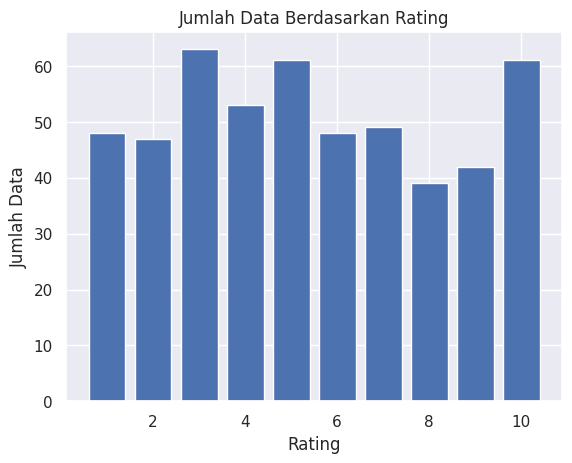

In [17]:
# Menghitung jumlah data untuk setiap rating
rating_counts = food_rating['Rating'].value_counts()

# Membuat grafik batang
plt.bar(rating_counts.index, rating_counts.values)

# Menambahkan label dan judul
plt.xlabel("Rating")
plt.ylabel("Jumlah Data")
plt.title("Jumlah Data Berdasarkan Rating")

# Menampilkan grafik
plt.show()

Grafik diatas menunjukkan visualisasi jumlah rating yang diberikan dari setiap konsumen.

In [18]:
# manampilkan tabel rating dan jenis makanan

# Kelompokkan data dan hitung jumlah data
rating_food_counts = food_rating.groupby(['Rating', 'C_Type']).size().unstack(fill_value=0)

# Hitung total per kolom
total_per_column = rating_food_counts.sum()

# Buat baris baru untuk total
total_row = pd.DataFrame(data=[total_per_column.values], columns=total_per_column.index, index=['Total'])

# Gabungkan baris total dengan DataFrame asli
rating_food_counts = pd.concat([rating_food_counts, total_row])

# Hitung total per baris dan tambahkan kolom 'Jumlah'
rating_food_counts['Jumlah'] = rating_food_counts.sum(axis=1)

# Tampilkan tabel
print("Jumlah Data Berdasarkan Rating dan Jenis Makanan:")
display(rating_food_counts)

Jumlah Data Berdasarkan Rating dan Jenis Makanan:


C_Type,Beverage,Chinese,Dessert,French,Healthy Food,Indian,Italian,Japanese,Snack,Thai,Mexican,Jumlah
1.0,1,3,6,3,9,12,4,3,6,1,0,48
2.0,2,2,12,2,5,9,4,2,2,3,4,47
3.0,0,2,15,4,4,14,3,9,9,0,3,63
4.0,1,1,9,6,10,10,2,5,5,3,1,53
5.0,1,3,15,0,8,10,6,1,7,4,6,61
6.0,1,2,5,3,10,9,2,4,6,3,3,48
7.0,1,2,4,5,6,15,2,6,4,3,1,49
8.0,1,2,13,0,4,10,3,1,1,0,4,39
9.0,3,1,10,1,6,9,3,4,2,2,1,42
10.0,3,2,13,3,11,14,6,1,4,2,2,61


Dengan penggabungna dataset, maka kita dapat informasi yang lebih rinci untuk setiap jenis makanan dan hasil ratingnya.
DAri informasi tersebut, dapat diperoleh informasi bahwa makanan india merupakan makanan yang paling banyak mendapatkan rating tertinggi sekaligus yang paling banyak mendapatkan rating terendah.
Hal ini mungkin karena jenis makanan india adalah makanan yang paling banyak jumlahnya.

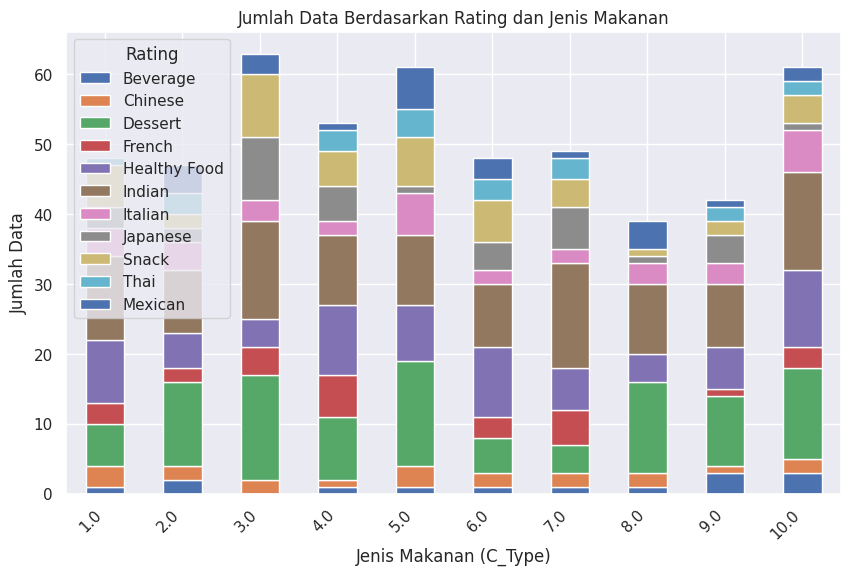

In [19]:
# Mengambil data dari tabel rating_food_counts
rating_food_counts = food_rating.groupby(['Rating', 'C_Type']).size().unstack(fill_value=0)

# Membuat grafik batang bertumpuk
rating_food_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Menambahkan label dan judul
plt.xlabel("Jenis Makanan (C_Type)")
plt.ylabel("Jumlah Data")
plt.title("Jumlah Data Berdasarkan Rating dan Jenis Makanan")
plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x agar mudah dibaca
plt.legend(title='Rating')

# Menampilkan grafik
plt.show()

Berikut adalah visualisasi yang menunjukkan jumlah rating pada setiap jenis makanan.

## 1.4. Cek data duplikat

In [20]:
food_rating.duplicated().sum()

0

Hasil cek data duplikasi menunjukkan tidak ada data duplikat.

In [21]:
# Pindahkan kolom 'User_ID' ke posisi paling kiri
food_rating = food_rating[['User_ID'] + [col for col in food_rating.columns if col != 'User_ID']]

# Menampilkan 5 baris pertama dari dataset yang sudah diubah
print(food_rating.head())

   User_ID  Food_ID                  Name        C_Type  Veg_Non  \
0     49.0        1   summer squash salad  Healthy Food      veg   
1     71.0        1   summer squash salad  Healthy Food      veg   
2      9.0        2  chicken minced salad  Healthy Food  non-veg   
3     22.0        2  chicken minced salad  Healthy Food  non-veg   
4     39.0        2  chicken minced salad  Healthy Food  non-veg   

                                            Describe  Rating  
0  white balsamic vinegar, lemon juice, lemon rin...     5.0  
1  white balsamic vinegar, lemon juice, lemon rin...    10.0  
2  olive oil, chicken mince, garlic (minced), oni...     3.0  
3  olive oil, chicken mince, garlic (minced), oni...     5.0  
4  olive oil, chicken mince, garlic (minced), oni...    10.0  


In [22]:
food_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User_ID   511 non-null    float64
 1   Food_ID   602 non-null    int64  
 2   Name      602 non-null    object 
 3   C_Type    602 non-null    object 
 4   Veg_Non   602 non-null    object 
 5   Describe  602 non-null    object 
 6   Rating    511 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 33.0+ KB


## 1.5. Cek data Kosong dan Nan

In [23]:
# Mengecek keberadaan nilai NaN di setiap kolom
print(food_rating.isna().any())

# Mengecek jumlah nilai NaN di setiap kolom
print(food_rating.isna().sum())

User_ID      True
Food_ID     False
Name        False
C_Type      False
Veg_Non     False
Describe    False
Rating       True
dtype: bool
User_ID     91
Food_ID      0
Name         0
C_Type       0
Veg_Non      0
Describe     0
Rating      91
dtype: int64


In [24]:
# Mengecek keberadaan data kosong di kolom bertipe object (string)
for col in food_rating.select_dtypes(include=['object']).columns:
    print(f"Kolom '{col}':")
    num_empty = food_rating[col].apply(lambda x: x.strip() == '').sum()
    print(f"  Jumlah data kosong: {num_empty}")

# Mengecek keberadaan nilai 0 di kolom numerik
for col in food_rating.select_dtypes(include=['number']).columns:
    print(f"Kolom '{col}':")
    num_zeros = (food_rating[col] == 0).sum()
    print(f"  Jumlah nilai 0: {num_zeros}")

Kolom 'Name':
  Jumlah data kosong: 0
Kolom 'C_Type':
  Jumlah data kosong: 0
Kolom 'Veg_Non':
  Jumlah data kosong: 0
Kolom 'Describe':
  Jumlah data kosong: 0
Kolom 'User_ID':
  Jumlah nilai 0: 0
Kolom 'Food_ID':
  Jumlah nilai 0: 0
Kolom 'Rating':
  Jumlah nilai 0: 0


In [25]:
# Menghitung jumlah data NaN di setiap kolom
na_counts = food_rating.isna().sum()

# Menampilkan jumlah total data NaN di seluruh dataset
total_na = na_counts.sum()

# Menampilkan hasil
print("Jumlah data NaN di setiap kolom:\n", na_counts)
print("\nTotal data NaN di seluruh dataset:", total_na)

Jumlah data NaN di setiap kolom:
 User_ID     91
Food_ID      0
Name         0
C_Type       0
Veg_Non      0
Describe     0
Rating      91
dtype: int64

Total data NaN di seluruh dataset: 182


# 2. Data Preprocessing dan Preparation

Tahapan ini dilakukan untuk mempersiapkan data supaya dapat dibbuat model dan proses lebih lanjut.

## 2.1. Cleaning data

Pada tahap ini, membersihkan data dari nilai-nilai yang hilang, duplikat. Langkah ini penting untuk memastikan kualitas data yang akan dianalisis lebih lanjut.

Hasil pemahaman data menunjukkan bahwa masalah data adalah hanya data NAN, yang terdapat pada kolom rating dan user id.

Oleh karena itu, langkah perbaikan data dilakukan dengan menghapus data NAN.

In [26]:
# Menghapus baris yang mengandung nilai NaN
food_rating = food_rating.dropna()

# Menampilkan jumlah baris dan kolom setelah menghapus data NaN
print("Ukuran dataset setelah menghapus data NaN:", food_rating.shape)

Ukuran dataset setelah menghapus data NaN: (511, 7)


Setelah data Nan dibapus, maka terdapat 511 data yang siap proses lanjut.

## 2.2. Perbaikan tipe data

Perbaikan tipe data ini supaya data angka dapat diperose lebih lanjut.

In [27]:
# Mengubah tipe data kolom 'User_ID' dan 'Rating' menjadi int
food_rating['User_ID'] = food_rating['User_ID'].astype(int)
food_rating['Rating'] = food_rating['Rating'].astype(int)

# Menampilkan informasi tipe data dari dataset food_rating
print(food_rating.info())

<class 'pandas.core.frame.DataFrame'>
Index: 511 entries, 0 to 510
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_ID   511 non-null    int64 
 1   Food_ID   511 non-null    int64 
 2   Name      511 non-null    object
 3   C_Type    511 non-null    object
 4   Veg_Non   511 non-null    object
 5   Describe  511 non-null    object
 6   Rating    511 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 31.9+ KB
None


<ipython-input-27-3d2f8afefb60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_rating['User_ID'] = food_rating['User_ID'].astype(int)
<ipython-input-27-3d2f8afefb60>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_rating['Rating'] = food_rating['Rating'].astype(int)


Data yang diubah adalah User_ID, Food_D, dan Rating

In [28]:
# hasil gabungan data
food_rating.head(5)

,User_ID,Food_ID,Name,C_Type,Veg_Non,Describe,Rating
0,49,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin...",5
1,71,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin...",10
2,9,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni...",3
3,22,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni...",5
4,39,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni...",10


## 2.3. Content Based Filtering

Membuat rekomendasi berdasarkan konten

### 2.3.1. TF-IDF Vectorizer

Pada tahap ini, kita akan membangun sistem rekomendasi sederhana berdasarkan jenis masakan yang disediakan restoran. Teknik ini juga akan digunakan pada sistem rekomendasi untuk menemukan representasi fitur penting dari setiap kategori masakan.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tf.fit(food['C_Type'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['beverage', 'chinese', 'dessert', 'food', 'french', 'healthy',
       'indian', 'italian', 'japanese', 'korean', 'mexican', 'nepalese',
       'snack', 'spanish', 'thai', 'vietnames'], dtype=object)

In [30]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(food['C_Type'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(400, 16)

In [31]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis masakan
# Baris diisi dengan nama resto

num_cols_to_sample = min(22, tfidf_matrix.shape[1])  # Ensure sample size doesn't exceed columns
num_rows_to_sample = min(10, tfidf_matrix.shape[0])  # Ensure sample size doesn't exceed rows

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=food.Name
).sample(num_cols_to_sample, axis=1, replace=False).sample(num_rows_to_sample, axis=0, replace=False)

,spanish,japanese,snack,dessert,french,chinese,beverage,italian,thai,korean,food,vietnames,indian,healthy,mexican,nepalese
Name,,,,,,,,,,,,,,,,
Miso-Butter Roast Chicken With Acorn Squash Panzanella,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
japanese curry arancini with barley salsa,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
thai prawn curry & baked rice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sweet and Sour Chicken Fried Rice,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
batter fish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
bread chana basket,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
flattened rice / poha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
pesto fish kebabs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Pasta with Garlic-Scape Pesto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3.2. Cosine similraity

Pada tahap sebelumnya, kita telah berhasil mengidentifikasi korelasi antara restoran dengan kategori masakannya. Sekarang, kita akan menghitung derajat kesamaan (similarity degree) antar restoran dengan teknik cosine similarity. Di sini, kita menggunakan fungsi cosine_similarity dari library sklearn.

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 0., 1.]])

In [34]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=food['Name'], columns=food['Name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (400, 400)


Name,coffee marinated mutton chops,spanish artichoke and spinach dip,chicken sukka,instant rava dosa,Chicken Momo
Name,,,,,
betel nut popsicle,0.0,0.0,0.0,0.0,0.0
Chicken Momo,0.0,0.0,0.0,0.0,1.0
sunga pork,0.0,0.0,0.0,0.0,0.0
berry parfait hazelnut white chocolate sable,0.0,0.0,0.0,0.0,0.0
vegetable som tam salad,0.0,0.0,0.0,0.0,0.0
jerk chicken,0.0,0.0,1.0,1.0,0.0
fruit infused tea,0.0,0.0,0.0,0.0,0.0
French Spiced Bread,0.0,0.0,0.0,0.0,0.0
spiced orange valencia cake,0.0,0.0,0.0,0.0,0.0


### 2.3.3. Mendapatkan Rekomendasi

Sebelumnya, kita telah memiliki data similarity (kesamaan) antar makanan. selanjutnya adalah menhasilkan sejumlah makanan yang akan direkomendasikan kepada pengguna.


Di sini, kita membuat fungsi resto_recommendations dengan beberapa parameter sebagai berikut:

Nama_makanan : Nama restoran (index kemiripan dataframe).

Similarity_data : Dataframe mengenai similarity yang telah kita definisikan sebelumnya.

Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘Name’ dan ‘C_Type’.

k : Banyak rekomendasi yang ingin diberikan.


Sebelum mulai menulis kodenya, ingatlah kembali definisi sistem rekomendasi yang menyatakan bahwa keluaran sistem ini adalah berupa top-N recommendation. Oleh karena itu, kita akan memberikan sejumlah rekomendasi restoran pada pengguna yang diatur dalam parameter k.


In [35]:
def food_recommendations(nama_makanan, similarity_data=cosine_sim_df, items=food[['Name', 'C_Type']], k=5):
    """
    Rekomendasi Resto berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_food : tipe data string (str)
                Nama Restoran (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_makanan].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_makanan, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Dengan menggunakan argpartition, kita mengambil sejumlah nilai k tertinggi dari similarity data (dalam kasus ini: dataframe cosine_sim_df). Kemudian, kita mengambil data dari bobot (tingkat kesamaan) tertinggi ke terendah. Data ini dimasukkan ke dalam variabel closest. Berikutnya, kita perlu menghapus nama_resto yang yang dicari agar tidak muncul dalam daftar rekomendasi. Dalam kasus ini, nanti kita akan mencari resto yang mirip dengan christmas cake, sehingga kita perlu drop nama_makanan christmas cake agar tidak muncul dalam daftar rekomendasi yang diberikan nanti.  

In [36]:
food[food.Name.eq('christmas cake')]

,Food_ID,Name,C_Type,Veg_Non,Describe
4,5,christmas cake,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."


In [37]:
# Mendapatkan rekomendasi restoran yang mirip dengan chrismas cake
food_recommendations('christmas cake')

,Name,C_Type
0,chocolate kaju katli,Dessert
1,eggless vanilla cake,Dessert
2,sweet potato pie,Dessert
3,eggless coffee cupcakes,Dessert
4,plum cake,Dessert


Berikut di atas adalah hasil dari sistem rekomendasi. Karena Christmas cake termasuk dalam dessert maka rekomenasi memunculkan menu dessert.

## 2.4. Collaborative Filtering

Collaborative filtering bergantung pada pendapat komunitas pengguna. Ia tidak memerlukan atribut untuk setiap itemnya seperti pada sistem berbasis konten. Collaborative filtering dibagi lagi menjadi dua kategori, yaitu: model based (metode berbasis model machine learning) dan memory based (metode berbasis memori).

### 2.4.1. Data preparation

Pertama, jangan lupa import semua library yang dibutuhkan. Seperti yang telah kita bahas sebelumnya, impor library di awal merupakan kebiasaan yang umum dilakukan oleh para praktisi data. Hal ini karena praktisi data kadang menggunakan IDE, tools, maupun lingkungan cloud lainnya. Sehingga, library perlu didefinisikan di awal.

In [38]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [39]:
# menunjukkan data yang akan diolah
rating.head()

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0


In [40]:
#Checking the shape
rating.shape

(512, 3)

In [41]:
# Checking for null values
rating.isnull().sum()

,0
User_ID,1
Food_ID,1
Rating,1


In [42]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB


In [43]:
rating.tail()

,User_ID,Food_ID,Rating
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0
511,NaN,NaN,NaN


In [44]:
# Removing the last row
rating = rating[:511]
rating.tail()

,User_ID,Food_ID,Rating
506,99.0,65.0,7.0
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0


In [45]:
rating.head()

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0


### 2.4.2. Encode Label

Pada tahap ini, Anda perlu melakukan persiapan data untuk menyandikan (encode) fitur ‘User_ID’ dan 'Food_ID' ke dalam indeks integer. Terapkan kode berikut.

In [46]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = rating['User_ID'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]
encoded userID :  {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 7.0: 6, 8.0: 7, 9.0: 8, 10.0: 9, 11.0: 10, 12.0: 11, 13.0: 12, 14.0: 13, 15.0: 14, 16.0: 15, 17.0: 16, 18.0: 17, 19.0: 18, 20.0: 19, 21.0: 20, 22.0: 21, 23.0: 22, 24.0: 23, 25.0: 24, 26.0: 25, 27.0: 26, 28.0: 27, 29.0: 28, 30.0: 29, 31.0: 30, 32.0: 31, 33.0: 32, 34.0: 33, 35.0: 34, 36.0: 35, 37.0: 36, 38.0: 37, 39.0: 38, 40.

Berikut adalah untuk Food_ID

In [47]:
# # Mengubah Food_ID menjadi list tanpa nilai yang sama
food_ids = rating['Food_ID'].unique().tolist()

# # Proses encoding placeID
food_to_food_encoded = {x: i for i, x in enumerate(food_ids)}

# # Proses decoding angka ke placeID
food_encoded_to_food = {i: x for i, x in enumerate(food_ids)}

---

Pemetaan User_ID dan Food_ID ke dataframe yang berkaitan.




In [48]:
# Mapping Food ID ke dataframe food
rating['food'] = rating['Food_ID'].map(food_to_food_encoded)

# Cek apakah ada nilai NaN setelah mapping
if rating['food'].isnull().sum() > 0:
    print("Ada nilai NaN dalam kolom 'food' setelah mapping.")


<ipython-input-48-064f9ab06d89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['food'] = rating['Food_ID'].map(food_to_food_encoded)


In [49]:
# Cek jumlah unique Food_IDs
print("Unique Food_IDs:", len(rating['Food_ID'].unique()))

# Cek panjang mapping
print("Food to Food Encoded Length:", len(food_to_food_encoded))

# Cek apakah ada nilai Food_ID yang tidak termapping
unmapped_food_ids = set(rating['Food_ID']) - set(food_to_food_encoded.keys())
if unmapped_food_ids:
    print("Unmapped Food_IDs:", unmapped_food_ids)
else:
    print("All Food_IDs are mapped correctly.")

Unique Food_IDs: 309
Food to Food Encoded Length: 309
All Food_IDs are mapped correctly.


In [50]:
# Cek nilai NaN pada kolom food
print("Jumlah NaN pada kolom 'food':", rating['food'].isnull().sum())

# Tampilkan baris dengan nilai NaN
if rating['food'].isnull().sum() > 0:
    print("Baris dengan NaN di kolom 'food':")
    print(rating[rating['food'].isnull()])

Jumlah NaN pada kolom 'food': 0


In [51]:
# Proses encoding yang benar
food_to_food_encoded = {x: i for i, x in enumerate(food_ids)}
food_encoded_to_food = {i: x for i, x in enumerate(food_ids)}

# Mapping kolom 'Food_ID' ke 'food'
rating['food'] = rating['Food_ID'].map(food_to_food_encoded)

<ipython-input-51-0146a4993779>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['food'] = rating['Food_ID'].map(food_to_food_encoded)


In [52]:
# Validasi nilai maksimum
# print("Max value in 'food':", rating['food'].max())
# assert rating['food'].max() < num_food, "Food ID encoding out of range!"

---

### 2.4.3. Mapping

In [53]:
# Mapping userID ke dataframe user
rating['user'] = rating['User_ID'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
rating['food'] = rating['Food_ID'].map(food_to_food_encoded)

<ipython-input-53-48079bd10161>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['user'] = rating['User_ID'].map(user_to_user_encoded)
<ipython-input-53-48079bd10161>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['food'] = rating['Food_ID'].map(food_to_food_encoded)


In [54]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_food = len(food_to_food_encoded)
print(num_food)

# Mengubah rating menjadi nilai float
rating['Rating'] = rating['Rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(rating['Rating'])

# Nilai maksimal rating
max_rating = max(rating['Rating'])

print('Number of User: {}, Number of Food: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_food, min_rating, max_rating
))

100
309
Number of User: 100, Number of Food: 309, Min Rating: 1.0, Max Rating: 10.0


<ipython-input-54-ce88ed614a69>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['Rating'] = rating['Rating'].values.astype(np.float32)


Tahap persiapan telah selesai. Berikut adalah hal-hal yang telah kita lakukan pada tahap ini:

Memahami data rating yang kita miliki.
Menyandikan (encode) fitur ‘User_ID’ dan ‘placeID’ ke dalam indeks integer.
Memetakan ‘User_ID’ dan ‘pl 'Food_ID’ ke dataframe yang berkaitan.
Mengecek beberapa hal dalam data seperti jumlah user, jumlah makanan, kemudian mengubah nilai rating menjadi float.

### 2.4.4. Validasi

Membuat data random dari data rating

In [55]:
# Mengacak dataset
rating = rating.sample(frac=1, random_state=42)
rating

,User_ID,Food_ID,Rating,food,user
124,24.0,51.0,5.0,67,23
84,16.0,243.0,3.0,78,15
433,83.0,79.0,1.0,282,82
255,49.0,77.0,10.0,191,48
68,13.0,74.0,8.0,64,12
...,...,...,...,...,...
106,19.0,84.0,10.0,97,18
270,51.0,151.0,10.0,200,50
348,67.0,146.0,7.0,209,66
435,84.0,253.0,8.0,283,83


---
### 2.4.5. Split data

kita bagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan makanan menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [56]:
# Membuat ulang x dan y
x = rating[['user', 'food']].values
y = rating['Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi dataset
train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)



In [57]:
# Cek nilai di x_train[:, 1] yang lebih besar dari num_food - 1
invalid_food_ids = x_train[:, 1][x_train[:, 1] >= num_food]
print("Invalid Food IDs in x_train:", invalid_food_ids)

Invalid Food IDs in x_train: []


---

In [58]:
# # Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
# x = rating[['user', 'food']].values

# # Membuat variabel y untuk membuat rating dari hasil
# y = rating['Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# # Membagi menjadi 80% data train dan 20% data validasi
# train_indices = int(0.8 * rating.shape[0])
# x_train, x_val, y_train, y_val = (
#     x[:train_indices],
#     x[train_indices:],
#     y[:train_indices],
#     y[train_indices:]
# )

# print(x, y)

###  2.4.6. Training

Pada tahap ini, model menghitung skor kecocokan antara pengguna dan makanan dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan resto. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan food. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan food. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

Di sini, kita membuat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam situs Keras dengan beberapa adaptasi sesuai kasus yang sedang kita selesaikan. Terapkan kode berikut.

In [59]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_food, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_food = num_food
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.food_embedding = layers.Embedding( # layer embeddings food
        num_food,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.food_bias = layers.Embedding(num_food, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    food_vector = self.food_embedding(inputs[:, -1]) # memanggil layer embedding 3
    food_bias = self.food_bias(inputs[:, -1]) # memanggil layer embedding 4

    dot_user_food = tf.tensordot(user_vector, food_vector, 2)

    x = dot_user_food + user_bias + food_bias

    return tf.nn.sigmoid(x) # activation sigmoid

# 3. Modeling

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

In [60]:
model = RecommenderNet(num_users, num_food, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Proses training adalah sebagai berikut

In [61]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6941 - root_mean_squared_error: 0.3230 - val_loss: 0.6950 - val_root_mean_squared_error: 0.3174
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6980 - root_mean_squared_error: 0.3161 - val_loss: 0.6960 - val_root_mean_squared_error: 0.3182
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6958 - root_mean_squared_error: 0.3232 - val_loss: 0.6969 - val_root_mean_squared_error: 0.3189
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6799 - root_mean_squared_error: 0.3025 - val_loss: 0.6975 - val_root_mean_squared_error: 0.3194
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - root_mean_squared_error: 0.3024 - val_loss: 0.6972 - val_root_mean_squared_error: 0.3192
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6761 - root_mean_squared_error: 0.3025 - val_loss: 0.6971 - val_root_mean_squared_error: 0.3190
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

### Visualisasi Metrik

Untuk melihat visualisasi proses training, mari kita plot metrik evaluasi dengan matplotlib. Terapkan kode berikut.

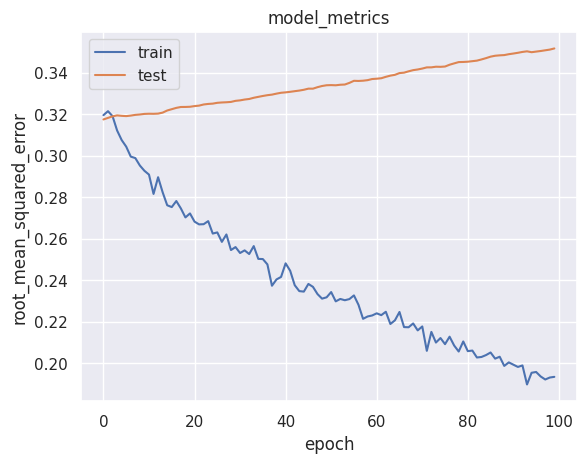

In [62]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 proses training model cukup smooth dan model konvergen pada epochs sekitar 100. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.19 dan error pada data validasi di atas 0.34.

## Mendapatkan Rekomendasi makanan

Untuk mendapatkan rekomendasi makanan, pertama kita ambil sampel user secara acak dan definisikan variabel food_not_reviewed yang merupakan daftar resto yang belum pernah dikunjungi oleh pengguna, menentukan daftar resto_not_revies perlu karena Hal ini karena daftar food_not_review inilah yang akan menjadi resto yang kita rekomendasikan.

In [63]:
food_df = food_rating
df = rating

# Mengambil sample user
user_id = df.User_ID.sample(1).iloc[0]
food_review_by_user = df[df.Food_ID == user_id]


# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
# Mengganti 'id' dengan 'Food_ID'
food_not_review = food_df[~food_df['Food_ID'].isin(food_review_by_user.Food_ID.values)]['Food_ID']
food_not_review = list(
    set(food_not_review)
    .intersection(set(food_to_food_encoded.keys()))
)

# Mengganti 'review_not_review' dengan 'food_not_review' dan 'User_ID' dengan 'user_id'
food_not_review = [[food_to_food_encoded.get(x)] for x in food_not_review]
user_encoder = user_to_user_encoded.get(user_id)
user_food_array = np.hstack(
    ([[user_encoder]] * len(food_not_review), food_not_review)
)

Selanjutnya, untuk memperoleh rekomendasi restoran, gunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [64]:
ratings = model.predict(user_food_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_food_ids = [
    food_encoded_to_food.get(food_not_review[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Food with high ratings from user')
print('----' * 8)

top_food_user = (
    food_review_by_user.sort_values(
        by='Rating',
        ascending=False
    )
    .head(5)
    .Food_ID.values
)

food_df_rows = food_df[food_df['Food_ID'].isin(top_food_user)]
# Remove duplicate rows based on 'Name' and 'C_Type'
food_df_rows = food_df_rows.drop_duplicates(subset=['Name', 'C_Type'])

for row in food_df_rows.itertuples():
    print(row.Name, ':', row.C_Type)

print('----' * 8)
print('Top 10 food recommendation')
print('----' * 8)

recommended_food = food_df[food_df['Food_ID'].isin(recommended_food_ids)]
# Remove duplicate rows based on 'Name' and 'C_Type'
recommended_food = recommended_food.drop_duplicates(subset=['Name', 'C_Type'])

for row in recommended_food.itertuples():
    print(row.Name, ':', row.C_Type)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Showing recommendations for users: 58.0
Food with high ratings from user
--------------------------------
dahi lasooni chicken : Indian
--------------------------------
Top 10 food recommendation
--------------------------------
summer squash salad : Healthy Food
chicken minced salad : Healthy Food
tricolour salad : Healthy Food
lamb and chargrilled bell pepper soup : Healthy Food
cream of almond soup : Healthy Food
broccoli and almond soup : Healthy Food
grilled almond barfi : Dessert
vegetable som tam salad : Healthy Food
spinach and feta crepes : French
almond and amaranth ladoo : Dessert


# Evaluasi